# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Setup PyTorch
All files are stored at /content/csc421/a3/ folder


In [1]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p /content/csc421/a3/
%cd /content/csc421/a3

    100% |████████████████████████████████| 5.6MB 4.4MB/s 
fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.1.post2 which is incompatible.
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
torchvision 0.2.2.post3 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


/content/csc421/a3


# Helper code

## Utility functions

In [0]:
import os
import pdb
import argparse
import pickle as pkl

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def to_var(tensor, cuda):
    """Wraps a Tensor in a Variable, optionally placing it on the GPU.

        Arguments:
            tensor: A Tensor object.
            cuda: A boolean flag indicating whether to use the GPU.

        Returns:
            A Variable object, on the GPU if cuda==True.
    """
    if cuda:
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


def create_dir_if_not_exists(directory):
    """Creates a directory if it doesn't already exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)


def save_loss_plot(train_losses, val_losses, opts):
    """Saves a plot of the training and validation loss curves.
    """
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(val_losses)), val_losses)
    plt.title('BS={}, nhid={}'.format(opts.batch_size, opts.hidden_size), fontsize=20)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(opts.checkpoint_path, 'loss_plot.pdf'))
    plt.close()


def checkpoint(encoder, decoder, idx_dict, opts):
    """Saves the current encoder and decoder models, along with idx_dict, which
    contains the char_to_index and index_to_char mappings, and the start_token
    and end_token values.
    """
    with open(os.path.join(opts.checkpoint_path, 'encoder.pt'), 'wb') as f:
        torch.save(encoder, f)

    with open(os.path.join(opts.checkpoint_path, 'decoder.pt'), 'wb') as f:
        torch.save(decoder, f)

    with open(os.path.join(opts.checkpoint_path, 'idx_dict.pkl'), 'wb') as f:
        pkl.dump(idx_dict, f)


## Data loader

In [0]:
def read_lines(filename):
    """Read a file and split it into lines.
    """
    lines = open(filename).read().strip().lower().split('\n')
    return lines


def read_pairs(filename):
    """Reads lines that consist of two words, separated by a space.

    Returns:
        source_words: A list of the first word in each line of the file.
        target_words: A list of the second word in each line of the file.
    """
    lines = read_lines(filename)
    source_words, target_words = [], []
    for line in lines:
        line = line.strip()
        if line:
            source, target = line.split()
            source_words.append(source)
            target_words.append(target)
    return source_words, target_words


def all_alpha_or_dash(s):
    """Helper function to check whether a string is alphabetic, allowing dashes '-'.
    """
    return all(c.isalpha() or c == '-' for c in s)


def filter_lines(lines):
    """Filters lines to consist of only alphabetic characters or dashes "-".
    """
    return [line for line in lines if all_alpha_or_dash(line)]


def load_data():
    """Loads (English, Pig-Latin) word pairs, and creates mappings from characters to indexes.
    """

    source_lines, target_lines = read_pairs('data/pig_latin_data.txt')

    # Filter lines
    source_lines = filter_lines(source_lines)
    target_lines = filter_lines(target_lines)

    all_characters = set(''.join(source_lines)) | set(''.join(target_lines))

    # Create a dictionary mapping each character to a unique index
    char_to_index = { char: index for (index, char) in enumerate(sorted(list(all_characters))) }

    # Add start and end tokens to the dictionary
    start_token = len(char_to_index)
    end_token = len(char_to_index) + 1
    char_to_index['SOS'] = start_token
    char_to_index['EOS'] = end_token

    # Create the inverse mapping, from indexes to characters (used to decode the model's predictions)
    index_to_char = { index: char for (char, index) in char_to_index.items() }

    # Store the final size of the vocabulary
    vocab_size = len(char_to_index)

    line_pairs = list(set(zip(source_lines, target_lines)))  # Python 3

    idx_dict = { 'char_to_index': char_to_index,
                 'index_to_char': index_to_char,
                 'start_token': start_token,
                 'end_token': end_token }

    return line_pairs, vocab_size, idx_dict


def create_dict(pairs):
    """Creates a mapping { (source_length, target_length): [list of (source, target) pairs]
    This is used to make batches: each batch consists of two parallel tensors, one containing
    all source indexes and the other containing all corresponding target indexes.
    Within a batch, all the source words are the same length, and all the target words are
    the same length.
    """
    unique_pairs = list(set(pairs))  # Find all unique (source, target) pairs

    d = defaultdict(list)
    for (s,t) in unique_pairs:
        d[(len(s), len(t))].append((s,t))

    return d


## Training and evaluation code

In [0]:
def string_to_index_list(s, char_to_index, end_token):
    """Converts a sentence into a list of indexes (for each character).
    """
    return [char_to_index[char] for char in s] + [end_token]  # Adds the end token to each index list


def translate_sentence(sentence, encoder, decoder, idx_dict, opts):
    """Translates a sentence from English to Pig-Latin, by splitting the sentence into
    words (whitespace-separated), running the encoder-decoder model to translate each
    word independently, and then stitching the words back together with spaces between them.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data()
    return ' '.join([translate(word, encoder, decoder, idx_dict, opts) for word in sentence.split()])


def translate(input_string, encoder, decoder, idx_dict, opts):
    """Translates a given string from English to Pig-Latin.
    """

    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_last_hidden = encoder(indexes)

    decoder_hidden = encoder_last_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    for i in range(max_generated_chars):
      ## slow decoding, recompute everything at each time
      decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden)
      generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
      ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
      ni = ni[-1] #latest output token

      decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)
      
      if ni == end_token:
          break
      else:
          gen_string = "".join(
              [index_to_char[int(item)] 
               for item in generated_words.cpu().numpy().reshape(-1)])

    return gen_string


def visualize_attention(input_string, encoder, decoder, idx_dict, opts):
    """Generates a heatmap to show where attention is focused in each decoder step.
    """
    if idx_dict is None:
      line_pairs, vocab_size, idx_dict = load_data()
    char_to_index = idx_dict['char_to_index']
    index_to_char = idx_dict['index_to_char']
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']

    max_generated_chars = 20
    gen_string = ''

    indexes = string_to_index_list(input_string, char_to_index, end_token)
    indexes = to_var(torch.LongTensor(indexes).unsqueeze(0), opts.cuda)  # Unsqueeze to make it like BS = 1

    encoder_annotations, encoder_hidden = encoder(indexes)

    decoder_hidden = encoder_hidden
    decoder_input = to_var(torch.LongTensor([[start_token]]), opts.cuda)  # For BS = 1
    decoder_inputs = decoder_input

    produced_end_token = False

    for i in range(max_generated_chars):
      ## slow decoding, recompute everything at each time
      decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, decoder_hidden)
      generated_words = F.softmax(decoder_outputs, dim=2).max(2)[1]
      ni = generated_words.cpu().numpy().reshape(-1)  # LongTensor of size 1
      ni = ni[-1] #latest output token
      
      decoder_inputs = torch.cat([decoder_input, generated_words], dim=1)
      
      if ni == end_token:
          break
      else:
          gen_string = "".join(
              [index_to_char[int(item)] 
               for item in generated_words.cpu().numpy().reshape(-1)])
    
    if isinstance(attention_weights, tuple):
      ## transformer's attention mweights
      attention_weights, self_attention_weights = attention_weights
    
    all_attention_weights = attention_weights.data.cpu().numpy()
    
    for i in range(len(all_attention_weights)):
      attention_weights_matrix = all_attention_weights[i].squeeze()
      fig = plt.figure()
      ax = fig.add_subplot(111)
      cax = ax.matshow(attention_weights_matrix, cmap='bone')
      fig.colorbar(cax)

      # Set up axes
      ax.set_yticklabels([''] + list(input_string) + ['EOS'], rotation=90)
      ax.set_xticklabels([''] + list(gen_string) + (['EOS'] if produced_end_token else []))

      # Show label at every tick
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
      # Add title
      plt.xlabel('Attention weights to the source sentence in layer {}'.format(i+1))
      plt.tight_layout()
      plt.grid('off')
      plt.show()
      #plt.savefig(save)

      #plt.close(fig)

    return gen_string


def compute_loss(data_dict, encoder, decoder, idx_dict, criterion, optimizer, opts):
    """Train/Evaluate the model on a dataset.

    Arguments:
        data_dict: The validation/test word pairs, organized by source and target lengths.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Train the weights if an optimizer is given. None if only evaluate the model. 
        opts: The command-line arguments.

    Returns:
        mean_loss: The average loss over all batches from data_dict.
    """
    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    losses = []
    for key in data_dict:
        input_strings, target_strings = zip(*data_dict[key])
        input_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in input_strings]
        target_tensors = [torch.LongTensor(string_to_index_list(s, char_to_index, end_token)) for s in target_strings]

        num_tensors = len(input_tensors)
        num_batches = int(np.ceil(num_tensors / float(opts.batch_size)))

        for i in range(num_batches):

            start = i * opts.batch_size
            end = start + opts.batch_size

            inputs = to_var(torch.stack(input_tensors[start:end]), opts.cuda)
            targets = to_var(torch.stack(target_tensors[start:end]), opts.cuda)

            # The batch size may be different in each epoch
            BS = inputs.size(0)

            encoder_annotations, encoder_hidden = encoder(inputs)

            # The last hidden state of the encoder becomes the first hidden state of the decoder
            decoder_hidden = encoder_hidden

            start_vector = torch.ones(BS).long().unsqueeze(1) * start_token  # BS x 1 --> 16x1  CHECKED
            decoder_input = to_var(start_vector, opts.cuda)  # BS x 1 --> 16x1  CHECKED

            loss = 0.0

            seq_len = targets.size(1)  # Gets seq_len from BS x seq_len

            decoder_inputs = torch.cat([decoder_input, targets[:, 0:-1]], dim=1)  # Gets decoder inputs by shifting the targets to the right 
            
            decoder_outputs, attention_weights = decoder(decoder_inputs, encoder_annotations, encoder_hidden)
            decoder_outputs_flatten = decoder_outputs.view(-1, decoder_outputs.size(2))
            targets_flatten = targets.view(-1)
            loss = criterion(decoder_outputs_flatten, targets_flatten)

            losses.append(loss.item())

            ## training if an optimizer is provided
            if optimizer:
              # Zero gradients
              optimizer.zero_grad()
              # Compute gradients
              loss.backward()
              # Update the parameters of the encoder and decoder
              optimizer.step()
              
    mean_loss = np.mean(losses)
    return mean_loss

  

def training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts):
    """Runs the main training loop; evaluates the model on the val set every epoch.
        * Prints training and val loss each epoch.
        * Prints qualitative translation results each epoch using TEST_SENTENCE
        * Saves an attention map for TEST_WORD_ATTN each epoch

    Arguments:
        train_dict: The training word pairs, organized by source and target lengths.
        val_dict: The validation word pairs, organized by source and target lengths.
        idx_dict: Contains char-to-index and index-to-char mappings, and start & end token indexes.
        encoder: An encoder model to produce annotations for each step of the input sequence.
        decoder: A decoder model (with or without attention) to generate output tokens.
        criterion: Used to compute the CrossEntropyLoss for each decoder output.
        optimizer: Implements a step rule to update the parameters of the encoder and decoder.
        opts: The command-line arguments.
    """

    start_token = idx_dict['start_token']
    end_token = idx_dict['end_token']
    char_to_index = idx_dict['char_to_index']

    loss_log = open(os.path.join(opts.checkpoint_path, 'loss_log.txt'), 'w')

    best_val_loss = 1e6
    train_losses = []
    val_losses = []

    for epoch in range(opts.nepochs):

        optimizer.param_groups[0]['lr'] *= opts.lr_decay
        
        train_loss = compute_loss(train_dict, encoder, decoder, idx_dict, criterion, optimizer, opts)
        val_loss = compute_loss(val_dict, encoder, decoder, idx_dict, criterion, None, opts)

        if val_loss < best_val_loss:
            checkpoint(encoder, decoder, idx_dict, opts)

        gen_string = translate_sentence(TEST_SENTENCE, encoder, decoder, idx_dict, opts)
        print("Epoch: {:3d} | Train loss: {:.3f} | Val loss: {:.3f} | Gen: {:20s}".format(epoch, train_loss, val_loss, gen_string))

        loss_log.write('{} {} {}\n'.format(epoch, train_loss, val_loss))
        loss_log.flush()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        save_loss_plot(train_losses, val_losses, opts)


def print_data_stats(line_pairs, vocab_size, idx_dict):
    """Prints example word pairs, the number of data points, and the vocabulary.
    """
    print('=' * 80)
    print('Data Stats'.center(80))
    print('-' * 80)
    for pair in line_pairs[:5]:
        print(pair)
    print('Num unique word pairs: {}'.format(len(line_pairs)))
    print('Vocabulary: {}'.format(idx_dict['char_to_index'].keys()))
    print('Vocab size: {}'.format(vocab_size))
    print('=' * 80)


def train(opts):
    line_pairs, vocab_size, idx_dict = load_data()
    print_data_stats(line_pairs, vocab_size, idx_dict)

    # Split the line pairs into an 80% train and 20% val split
    num_lines = len(line_pairs)
    num_train = int(0.8 * num_lines)
    train_pairs, val_pairs = line_pairs[:num_train], line_pairs[num_train:]

    # Group the data by the lengths of the source and target words, to form batches
    train_dict = create_dict(train_pairs)
    val_dict = create_dict(val_pairs)

    ##########################################################################
    ### Setup: Create Encoder, Decoder, Learning Criterion, and Optimizers ###
    ##########################################################################
    encoder = GRUEncoder(vocab_size=vocab_size, 
                         hidden_size=opts.hidden_size, 
                         opts=opts)

    if opts.decoder_type == 'rnn':
        decoder = RNNDecoder(vocab_size=vocab_size, 
                             hidden_size=opts.hidden_size)
    elif opts.decoder_type == 'rnn_attention':
        decoder = RNNAttentionDecoder(vocab_size=vocab_size, 
                                      hidden_size=opts.hidden_size, 
                                      attention_type=opts.attention_type)
    elif opts.decoder_type == 'transformer':
        decoder = TransformerDecoder(vocab_size=vocab_size, 
                                     hidden_size=opts.hidden_size, 
                                     num_layers=opts.num_transformer_layers)
    else:
        raise NotImplementedError
        
    #### setup checkpoint path
    model_name = 'h{}-bs{}-{}'.format(opts.hidden_size, 
                                      opts.batch_size, 
                                      opts.decoder_type)
    opts.checkpoint_path = model_name
    create_dir_if_not_exists(opts.checkpoint_path)
    ####

    if opts.cuda:
        encoder.cuda()
        decoder.cuda()
        print("Moved models to GPU!")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=opts.learning_rate)

    try:
        training_loop(train_dict, val_dict, idx_dict, encoder, decoder, criterion, optimizer, opts)
    except KeyboardInterrupt:
        print('Exiting early from training.')
        return encoder, decoder
      
    return encoder, decoder


def print_opts(opts):
    """Prints the values of all command-line arguments.
    """
    print('=' * 80)
    print('Opts'.center(80))
    print('-' * 80)
    for key in opts.__dict__:
        print('{:>30}: {:<30}'.format(key, opts.__dict__[key]).center(80))
    print('=' * 80)


# Your code for NMT models

## GRU cell

In [0]:
class MyGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyGRUCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # ------------
        ## Input linear layers
        self.Wiz = nn.Linear(input_size, hidden_size)
        self.Wir = nn.Linear(input_size, hidden_size)
        self.Wih = nn.Linear(input_size, hidden_size)

        ## Hidden linear layers
        self.Whz = nn.Linear(hidden_size, hidden_size)
        self.Whr = nn.Linear(hidden_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        # ------------        


    def forward(self, x, h_prev):
        """Forward pass of the GRU computation for one time step.

        Arguments
            x: batch_size x input_size
            h_prev: batch_size x hidden_size

        Returns:
            h_new: batch_size x hidden_size
        """

        # ------------
        z = torch.sigmoid(self.Wiz(x) + self.Whz(h_prev)) # could also use F.Sigmoid (depricated)
        r = torch.sigmoid(self.Wir(x) + self.Whr(h_prev))
        g = torch.tanh(self.Wih(x) + r*self.Whh(h_prev))
        h_new = (1-z)*g + z*h_prev
        return h_new
        # ------------

        

### GRU encoder / decoder

In [0]:
class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, opts):
        super(GRUEncoder, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.opts = opts

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRUCell(hidden_size, hidden_size)

    def forward(self, inputs):
        """Forward pass of the encoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all time steps in the sequence. (batch_size x seq_len)

        Returns:
            annotations: The hidden states computed at each step of the input sequence. (batch_size x seq_len x hidden_size)
            hidden: The final hidden state of the encoder, for each sequence in a batch. (batch_size x hidden_size)
        """

        batch_size, seq_len = inputs.size()
        hidden = self.init_hidden(batch_size)

        encoded = self.embedding(inputs)  # batch_size x seq_len x hidden_size
        annotations = []

        for i in range(seq_len):
            x = encoded[:,i,:]  # Get the current time step, across the whole batch
            hidden = self.gru(x, hidden)
            annotations.append(hidden)

        annotations = torch.stack(annotations, dim=1)
        return annotations, hidden

    def init_hidden(self, bs):
        """Creates a tensor of zeros to represent the initial hidden states
        of a batch of sequences.

        Arguments:
            bs: The batch size for the initial hidden state.

        Returns:
            hidden: An initial hidden state of all zeros. (batch_size x hidden_size)
        """
        return to_var(torch.zeros(bs, self.hidden_size), self.opts.cuda)


class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(RNNDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRUCell(input_size=hidden_size, hidden_size=hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the non-attentional decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch. (batch_size x seq_len)
            annotations: This is not used here. It just maintains consistency with the
                    interface used by the AttentionDecoder class.
            hidden_init: The hidden states from the last step of encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            None
        """        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        h_prev = hidden_init
        for i in range(seq_len):
            x = embed[:,i,:]  # Get the current time step input tokens, across the whole batch
            h_prev = self.rnn(x, h_prev)  # batch_size x hidden_size
            hiddens.append(h_prev)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, None      


## Attention

In [0]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size):
        super(AdditiveAttention, self).__init__()

        self.hidden_size = hidden_size

        # A two layer fully-connected network
        # hidden_size*2 --> hidden_size, ReLU, hidden_size --> 1
        self.attention_network = nn.Sequential(
                                    nn.Linear(hidden_size*2, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1)
                                 )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, queries, keys, values):
        """The forward pass of the additive attention mechanism.

        Arguments:
            queries: The current decoder hidden state. (batch_size x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x 1 x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x 1)

            The attention_weights must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        batch_size = queries.size(0) # could also do keys.shape
        expanded_queries = queries.unsqueeze(1).expand_as(keys) # keys.size() gives ERROR! queries 2D --> 3D dimention needs to be same shape as keys dimension, both 3D
        concat_inputs = torch.cat((expanded_queries, keys),2) # try with 1
        unnormalized_attention = self.attention_network(concat_inputs)
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.squeeze(2).unsqueeze(1), values) # or torch.sum(attention_weights*values, 1)
        return context, attention_weights
        # ------------
      

class ScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(ScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x k)

            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        batch_size = queries.size(0)
        q = self.Q(queries.unsqueeze(1)) if len(queries.size()) == 2 else self.Q(queries) # W_q * Q_t
        k = self.K(keys) # W_k K-i
        v = self.V(values) # V_i
        
        unnormalized_attention = k.bmm(q.permute(0,2,1)) * self.scaling_factor 
        attention_weights = self.softmax(unnormalized_attention)
        context = torch.bmm(attention_weights.permute(0,2,1), v)
        return context, attention_weights
        # ------------
      
      
class CausalScaledDotAttention(nn.Module):
    def __init__(self, hidden_size):
        super(CausalScaledDotAttention, self).__init__()

        self.hidden_size = hidden_size
        self.neg_inf = torch.tensor(-1e7)

        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.scaling_factor = torch.rsqrt(torch.tensor(self.hidden_size, dtype= torch.float))

    def forward(self, queries, keys, values):
        """The forward pass of the scaled dot attention mechanism.

        Arguments:
            queries: The current decoder hidden state, 2D or 3D tensor. (batch_size x (k) x hidden_size)
            keys: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            values: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)

        Returns:
            context: weighted average of the values (batch_size x k x hidden_size)
            attention_weights: Normalized attention weights for each encoder hidden state. (batch_size x seq_len x k)
            
            The output must be a softmax weighting over the seq_len annotations.
        """

        # ------------
        batch_size = queries.size(0)
        q = self.Q(queries.unsqueeze(1)) if len(queries.size()) == 2 else self.Q(queries)
        k = self.K(keys) 
        v = self.V(values) 
        unnormalized_attention = k.bmm(q.permute(0, 2, 1)) * self.scaling_factor 
        mask = torch.tril(torch.ones_like(unnormalized_attention), diagonal=-1) * self.neg_inf
        attention_weights = self.softmax(unnormalized_attention + mask)
        context =  attention_weights.permute(0, 2, 1).bmm(v)
        return context, attention_weights
        # ------------

### Attention decoder

In [0]:
class RNNAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, attention_type='scaled_dot'):
        super(RNNAttentionDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.rnn = MyGRUCell(input_size=hidden_size*2, hidden_size=hidden_size)
        if attention_type == 'additive':
          self.attention = AdditiveAttention(hidden_size=hidden_size)
        elif attention_type == 'scaled_dot':
          self.attention = ScaledDotAttention(hidden_size=hidden_size)
        
        self.out = nn.Linear(hidden_size, vocab_size)

        
    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input sequence. (batch_size x seq_len x hidden_size)
            hidden_init: The final hidden states from the encoder, across a batch. (batch_size x hidden_size)

        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        hiddens = []
        attentions = []
        h_prev = hidden_init
        for i in range(seq_len):
            # ------------
            embed_current = embed[:,i,:]
            context, attention_weights = self.attention(h_prev, annotations, annotations)
            embed_and_context = torch.cat((context.squeeze(1), embed_current),1) 
            h_prev = self.rnn(embed_and_context, h_prev)
            # ------------
            
            hiddens.append(h_prev)
            attentions.append(attention_weights)

        hiddens = torch.stack(hiddens, dim=1) # batch_size x seq_len x hidden_size
        attentions = torch.cat(attentions, dim=2) # batch_size x seq_len x seq_len
        
        output = self.out(hiddens)  # batch_size x seq_len x vocab_size
        return output, attentions
        

### Transformer decoder

In [0]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)        
        self.num_layers = num_layers
        
        self.self_attentions = nn.ModuleList([CausalScaledDotAttention( #currently in causal mode, for non-causal: self.self_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.encoder_attentions = nn.ModuleList([ScaledDotAttention(
                                    hidden_size=hidden_size, 
                                 ) for i in range(self.num_layers)])
        self.attention_mlps = nn.ModuleList([nn.Sequential(
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                 ) for i in range(self.num_layers)])
        self.out = nn.Linear(hidden_size, vocab_size)

        
    def forward(self, inputs, annotations, hidden_init):
        """Forward pass of the attention-based decoder RNN.

        Arguments:
            inputs: Input token indexes across a batch for all the time step. (batch_size x decoder_seq_len)
            annotations: The encoder hidden states for each step of the input.
                         sequence. (batch_size x seq_len x hidden_size)
            hidden_init: Not used in the transformer decoder
        Returns:
            output: Un-normalized scores for each token in the vocabulary, across a batch for all the decoding time steps. (batch_size x decoder_seq_len x vocab_size)
            attentions: The stacked attention weights applied to the encoder annotations (batch_size x encoder_seq_len x decoder_seq_len)
        """
        
        batch_size, seq_len = inputs.size()
        embed = self.embedding(inputs)  # batch_size x seq_len x hidden_size        

        encoder_attention_weights_list = []
        self_attention_weights_list = []
        contexts = embed
        for i in range(self.num_layers):
          # ------------
          new_contexts, self_attention_weights = self.self_attentions[i](contexts, contexts, contexts)
          residual_contexts = new_contexts + contexts
          new_contexts, encoder_attention_weights = self.encoder_attentions[i](residual_contexts, annotations, annotations)
          residual_contexts = residual_contexts + new_contexts
          new_contexts = self.attention_mlps[i](residual_contexts)
          contexts = residual_contexts + new_contexts
          # ------------

          encoder_attention_weights_list.append(encoder_attention_weights)
          self_attention_weights_list.append(self_attention_weights)
          
        output = self.out(contexts)
        encoder_attention_weights = torch.stack(encoder_attention_weights_list)
        self_attention_weights = torch.stack(self_attention_weights_list)
        
        return output, (encoder_attention_weights, self_attention_weights)

# Training


## Download dataset

In [10]:
######################################################################
# Download Translation datasets
######################################################################
data_fpath = get_file(fname='pig_latin_data.txt', 
                         origin='http://www.cs.toronto.edu/~jba/pig_latin_data.txt', 
                         untar=False)

data/pig_latin_data.txt
('Downloading data from', 'http://www.cs.toronto.edu/~jba/pig_latin_data.txt')


## RNN decoder

In [27]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'decoder_type': 'rnn', # options: rnn / rnn_attention / transformer
              'attention_type': '',  # options: additive / scaled_dot
}
args.update(args_dict)

print_opts(args)
rnn_encoder, rnn_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, rnn_encoder, rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                            hidden_size: 20                                     
                          learning_rate: 0.005                                  
                             batch_size: 64                                     
                                nepochs: 100                                    
                                   cuda: 1                                      
                         checkpoint_dir: checkpoints                            
                           decoder_type: rnn                                    
                               lr_decay: 0.99                                   
                         attention_type:                                        
                                   Data Stats                                   
----------------------------

In [0]:
TEST_SENTENCE = 'the british-born sixty nine year old is known as the godfather of the strain of artificial intelligence called neural networks or neural nets which involves setting up computer systems to mimic the human brain allowing them to learn it is some experts say going to radically transform our lives already is actually the way electricity did'
translated = translate_sentence(TEST_SENTENCE, rnn_encoder, rnn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

## RNN attention decoder

In [11]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'decoder_type': 'rnn_attention', # options: rnn / rnn_attention / transformer
              'attention_type': 'additive',  # options: additive / scaled_dot
}
args.update(args_dict)

print_opts(args)
rnn_attn_encoder, rnn_attn_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                            hidden_size: 20                                     
                          learning_rate: 0.005                                  
                             batch_size: 64                                     
                                nepochs: 100                                    
                                   cuda: 1                                      
                         checkpoint_dir: checkpoints                            
                           decoder_type: rnn_attention                          
                               lr_decay: 0.99                                   
                         attention_type: additive                               
                                   Data Stats                                   
----------------------------

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RNNAttentionDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MyGRUCell. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type AdditiveAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   0 | Train loss: 2.351 | Val loss: 1.942 | Gen: eray ay inessay inssay inessay
Epoch:   1 | Train loss: 1.850 | Val loss: 1.706 | Gen: eray ay ingesingay isisisisisisisisisis onstestestay
Epoch:   2 | Train loss: 1.586 | Val loss: 1.423 | Gen: eray aitsay oningingay istay oringsay
Epoch:   3 | Train loss: 1.347 | Val loss: 1.219 | Gen: eday ay-ioray ontiningay isthay orsinghay
Epoch:   4 | Train loss: 1.114 | Val loss: 1.015 | Gen: etay ay-iray ondicinghay issay orsinghay
Epoch:   5 | Train loss: 0.929 | Val loss: 0.871 | Gen: etay airway ondicingay issay orkinghay
Epoch:   6 | Train loss: 0.831 | Val loss: 0.819 | Gen: etay airsay onditiongay issay orkinghay
Epoch:   7 | Train loss: 0.757 | Val loss: 0.785 | Gen: ethay airway onditingay ishay orkinghay
Epoch:   8 | Train loss: 0.703 | Val loss: 0.876 | Gen: etay airway onditiongay issay orkingsay
Epoch:   9 | Train loss: 0.665 | Val loss: 0.638 | Gen: etay airway onditioningay ishay orkinghay
Epoch:  10 | Train loss: 0.567 | V

In [0]:
TEST_SENTENCE = 'the british-born sixty nine year old is known as the godfather of the strain of artificial intelligence called neural networks or neural nets which involves setting up computer systems to mimic the human brain allowing them to learn it is some experts say going to radically transform our lives already is actually the way electricity did'
translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the british-born sixty nine year old is known as the godfather of the strain of artificial intelligence called neural networks or neural nets which involves setting up computer systems to mimic the human brain allowing them to learn it is some experts say going to radically transform our lives already is actually the way electricity did 
translated:	ethay itishbay-ornbay ixtysay inenay yearay oldway isway ownknay asway ethay odfathergay ofway ethay ainstray ofway artificialway intelligenceway alledcay euralnay etworksnay orway euralnay etsnay ichwhay involvesway ettingsay upway omputercay ystemssay otay imicmay ethay umanhay ainbray allowingway emthay otay earnlay itway isway omesay expertsway aysay oinggay otay adicallyray ansformtray ourway iveslay alreadyway isway actuallyway ethay ayway electricityway idday


In [52]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'decoder_type': 'rnn_attention', # options: rnn / rnn_attention / transformer
              'attention_type': 'scaled_dot',  # options: additive / scaled_dot
}
args.update(args_dict)

print_opts(args)
rnn_attn_encoder, rnn_attn_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                            hidden_size: 20                                     
                          learning_rate: 0.005                                  
                             batch_size: 64                                     
                                nepochs: 100                                    
                                   cuda: 1                                      
                         checkpoint_dir: checkpoints                            
                           decoder_type: rnn_attention                          
                               lr_decay: 0.99                                   
                         attention_type: scaled_dot                             
                                   Data Stats                                   
----------------------------

In [0]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, rnn_attn_encoder, rnn_attn_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

## Transformer

In [12]:
TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
args.update(args_dict)

print_opts(args)
transformer_encoder, transformer_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

                                      Opts                                      
--------------------------------------------------------------------------------
                            hidden_size: 20                                     
                          learning_rate: 0.005                                  
                 num_transformer_layers: 3                                      
                             batch_size: 64                                     
                                nepochs: 100                                    
                                   cuda: 1                                      
                         checkpoint_dir: checkpoints                            
                           decoder_type: transformer                            
                               lr_decay: 0.99                                   
                                   Data Stats                                   
----------------------------

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CausalScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   0 | Train loss: 2.199 | Val loss: 1.730 | Gen: eray iray oningngngngngngngngn isisisisisisisisisis ongay
Epoch:   1 | Train loss: 1.601 | Val loss: 1.359 | Gen: eththay airay oningingngingngnging isissisgsgsgsgsgsisg otinggray
Epoch:   2 | Train loss: 1.229 | Val loss: 1.087 | Gen: ehthay airay onginglay isgrisgsgray orcingray
Epoch:   3 | Train loss: 0.963 | Val loss: 0.878 | Gen: ehay airay ongingway isway orkingway
Epoch:   4 | Train loss: 0.791 | Val loss: 0.717 | Gen: ethay airway ondiongiongway isway orkingway
Epoch:   5 | Train loss: 0.598 | Val loss: 0.618 | Gen: ethay airway onininingway isway orkingway
Epoch:   6 | Train loss: 0.526 | Val loss: 0.538 | Gen: ethay airway onininingway isway orkingway
Epoch:   7 | Train loss: 0.403 | Val loss: 0.496 | Gen: ehay airay onditingway isway orkingway
Epoch:   8 | Train loss: 0.374 | Val loss: 0.438 | Gen: ethay airay ondingcay isway orkingway
Epoch:   9 | Train loss: 0.337 | Val loss: 0.392 | Gen: ethay airay onditingcay iswa

In [25]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	ethay airway onditiongcay isway orkingway


In [12]:
print("============ These results will be those using non-causal attention ============")

TEST_SENTENCE = 'the air conditioning is working'

args = AttrDict()
args_dict = {
              'cuda':True, 
              'nepochs':100, 
              'checkpoint_dir':"checkpoints", 
              'learning_rate':0.005, 
              'lr_decay':0.99,
              'batch_size':64, 
              'hidden_size':20, 
              'decoder_type': 'transformer', # options: rnn / rnn_attention / transformer
              'num_transformer_layers': 3,
}
args.update(args_dict)

print_opts(args)
transformer_encoder, transformer_decoder = train(args)

translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

============ These results will be those using non-causal attention ============
                                      Opts                                      
--------------------------------------------------------------------------------
                            hidden_size: 20                                     
                          learning_rate: 0.005                                  
                 num_transformer_layers: 3                                      
                             batch_size: 64                                     
                                nepochs: 100                                    
                                   cuda: 1                                      
                         checkpoint_dir: checkpoints                            
                           decoder_type: transformer                            
                               lr_decay: 0.99                                   
                            

/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type GRUEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type TransformerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python2.7/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ScaledDotAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:   0 | Train loss: 2.174 | Val loss: 1.714 | Gen: tttttttttttttttttttt rrrrrrrrrrrrrrrrrrrr  yyyyyyyyyyyyyyyyyyyy ay
Epoch:   1 | Train loss: 1.605 | Val loss: 1.394 | Gen:  alalalalalalalalalal  - 
Epoch:   2 | Train loss: 1.302 | Val loss: 1.160 | Gen: eththththththththtth ariririririririririr  -------------------- 
Epoch:   3 | Train loss: 1.091 | Val loss: 0.948 | Gen:  my onayEOSayay isisisisisisisisisis orgrgrgrgrgrgrggrgrg
Epoch:   4 | Train loss: 0.916 | Val loss: 0.840 | Gen: ethay aaaaaaaaaaaaaaaaaaaa onininininininininin isisy orkinkinkinkinkinkik
Epoch:   5 | Train loss: 0.877 | Val loss: 0.774 | Gen: ethethethethethethet airpairpairpairpairp onininininininininin isisisisisisisisisis oraEOSy
Epoch:   6 | Train loss: 0.690 | Val loss: 0.662 | Gen: ethethethethethethet  onininininininininin isisisisisisisisisis oraaayEOSy
Epoch:   7 | Train loss: 0.630 | Val loss: 0.673 | Gen: ethaaEOSayayyy airairairairairairai onininininininininin isisisisisisisisisis orgingingingingi

In [13]:
TEST_SENTENCE = 'the air conditioning is working'
translated = translate_sentence(TEST_SENTENCE, transformer_encoder, transformer_decoder, None, args)
print("source:\t\t{} \ntranslated:\t{}".format(TEST_SENTENCE, translated))

source:		the air conditioning is working 
translated:	   isay 


# Attention visualization

In [0]:
TEST_WORD_ATTN = 'pneumonoultramicroscopicsilicovolcanoconiosis'

## Visualize RNN attention map

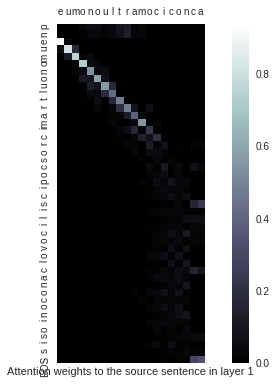

'eumonoultramociconca'

In [36]:
visualize_attention(TEST_WORD_ATTN, rnn_attn_encoder, rnn_attn_decoder, None, args)

## Visualize transformer attention maps from all the transformer layers

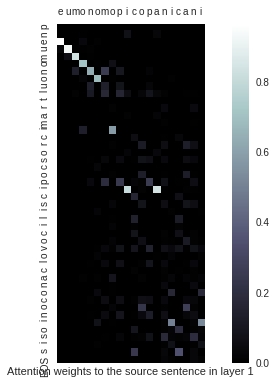

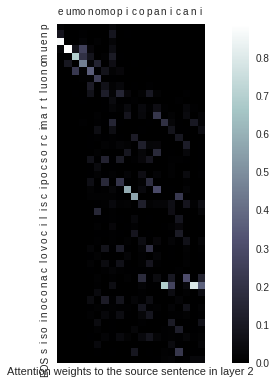

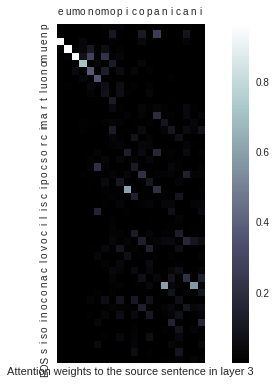

'eumonomopicopanicani'

In [37]:
visualize_attention(TEST_WORD_ATTN, transformer_encoder, transformer_decoder, None, args, )